In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import sys
sys.path.append('../src/')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
from mock_test import *
#from run_error_analysis import *
#from plot_chain import plot_single, plot_triple, plot_distributions, plot_summary_bar
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Initialize Class, Calculate datavector and cov matrices

In [21]:
def fractional_error_on_f(z=0.59, bD=2.0, f = None, s = 3.5, nn=3.0e-04, Vs=5.0e+09, kmax=0.1, verbose=True):
    """
     b = galaxy bias
     f = structure growth rate
     s = velocity dispersion in FoG term 
     nn = shot noise 
    """
    
    cosmo = class_covariance(z=z, 
                         KMIN=0.001, KMAX = 5, n=5000, 
                         RMIN = 0.001, RMAX = 200, n2 = 101, \
                         b = 0.0, f = 0.0, s=3.5, nn=nn, Vs=Vs,
                         rscale = 'lin', kscale='lin', 
                         smooth_filter=False)

    if verbose: print 'redshift=',cosmo.z

    #cosmo.compile_fortran_modules()
    cosmo.MatterPower(z=z)

    
    if f is None: f = cosmo.compute_fz(z=z)
    cosmo.f = f
    if verbose: print 'f(z)=',cosmo.f
    
    growth = cosmo.cosmology.growthFactor(z)
    cosmo.b = bD/growth
    
    if verbose:
        print 'bD(z)=',cosmo.b*growth
        print 'b(z={:0.2f})={:0.2f}'.format(cosmo.z, cosmo.b)
    
    Pkmu14 = cosmo.Pkmu(0.14, 1.6)
    Pkmu20 = cosmo.Pkmu(0.2, 0)
    if verbose:
        print 'nP14={:0.2f}'.format(cosmo.nn * Pkmu14)
        print 'nP20={:0.2f}'.format(cosmo.nn * Pkmu20)
    
    sigma8_0 = cosmo.compute_sigma8(z=0.0)
    sigma8 = cosmo.compute_sigma8(z=z)

    cov_bf = cosmo.Pkmu_FisherComputation(kmin=cosmo.KMIN, kmax=kmax, Nq=2)
    if verbose:
        # print out results-------------------------------
        print '---------------------------------\
        \n Cov matrix of b and f (Theory) \n{} \
        \n---------------------------------'.format(cov_bf)
  
    sigma_b = np.sqrt(cov_bf[0,0])
    sigma_f = np.sqrt(cov_bf[1,1])
    fractional_err_b = sigma_b/cosmo.b * 100
    fractional_err_f = sigma_f/cosmo.f * 100

    if verbose:
        print 'error on bsig8: {:0.4f}'.format(sigma_b* sigma8)
        print 'error on fsig8: {:0.4f}'.format(sigma_f* sigma8)
        print 'fractional error db/b: {:0.2f}%'.format(fractional_err_b)
        print 'fractional error df/f: {:0.2f}%'.format(fractional_err_f)
        print 'bsig8(z)={:0.4f}'.format(cosmo.b * sigma8)
        print 'fsig8(z)={:0.4f}'.format(cosmo.f * sigma8)

    #sigma8 = 1
    return [cosmo.b * sigma8, cosmo.f*sigma8], [fractional_err_b,fractional_err_f], \
[sigma_b*sigma8, sigma_f*sigma8], cov_bf[:2,:2]*sigma8**2
    

In [48]:
def sum_finebin_errors(Dic):
    
    z = Dic['z']
    Vs = Dic['Vs']
    nn = Dic['nbar']
    bD = Dic['bD']

    
    # fiducial quantity at z_eff
    z_eff = Dic['z_eff']
    params, _, _, _ = fractional_error_on_f(z=z_eff, \
                bD=bD, s = 3.5,nn=Dic['nbar_total'], Vs=Dic['Vs_total'], kmax=0.1)
    
    
    Nq = 2
    params_array = np.zeros((Nq,z.size)) #np.zeros(zarray.size)
    err_array = np.zeros((Nq,z.size)) #np.zeros(zarray.size)
    cov_bfs8_array = np.zeros((Nq,Nq,z.size))
    for i in range(z.size):
        
        if nn[i] == 0: pass
        else:
            params_array[:,i], _, err_array[:,i], cov_bfs8_array[:,:,i] \
            = fractional_error_on_f(z=z[i], bD=bD, s = 3.5, nn=nn[i], Vs=Vs[i], kmax=0.1, verbose=False)

    # combination
    
    sum_fisher = np.zeros((Nq, Nq))
    for i in range(z.size):
           
        if nn[i] == 0: pass
        else:
            sum_fisher += np.linalg.inv(cov_bfs8_array[:,:,i])

    sum_cov = np.linalg.inv(sum_fisher)
    sum_err = np.sqrt(sum_cov.diagonal())
    sum_fracerr = [ sum_err[i]/params[i] for i in range(Nq) ]
    
    print 'z_eff=', z_eff
    print 'error on bs8: {:0.4f}'.format(sum_err[0])
    print 'error on fs8: {:0.4f}'.format(sum_err[1])
    print 'fractional error db/b: {:0.2f}%'.format(sum_fracerr[0]*100)
    print 'fractional error df/f: {:0.2f}%'.format(sum_fracerr[1]*100)
    print 'bsig8(z)={:0.4f}'.format(params[0])
    print 'fsig8(z)={:0.4f}'.format(params[1])
        
    return params, sum_fracerr, sum_err, sum_cov


In [17]:
params = {'flat': True, 'H0': 67.85960, 'Om0': 3.057076e-01, 'Ob0': 4.845864e-02, 'sigma8': 0.8235, 'ns':9.683760e-01}
cosmo_planck = class_covariance(cosmology = params, z=0.0, 
                 KMIN=0.001, KMAX = 50, n=5001)
cosmo_planck.MatterPower(z=0.0)
zbins = np.linspace(0, 2.0, 21)
fz_theory = cosmo_planck.compute_fz(z=zbins)
sigma8_array = [cosmo_planck.compute_sigma8(z=z_i) for z_i in zbins]

compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.10)=0.78
sigma8(z=0.20)=0.74
sigma8(z=0.30)=0.70
sigma8(z=0.40)=0.67
sigma8(z=0.50)=0.64
sigma8(z=0.60)=0.60
sigma8(z=0.70)=0.58
sigma8(z=0.80)=0.55
sigma8(z=0.90)=0.52
sigma8(z=1.00)=0.50
sigma8(z=1.10)=0.48
sigma8(z=1.20)=0.46
sigma8(z=1.30)=0.44
sigma8(z=1.40)=0.43
sigma8(z=1.50)=0.41
sigma8(z=1.60)=0.40
sigma8(z=1.70)=0.38
sigma8(z=1.80)=0.37
sigma8(z=1.90)=0.36
sigma8(z=2.00)=0.35


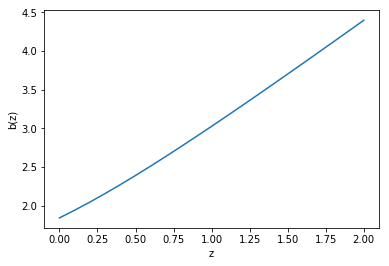

In [328]:
fig, ax = plt.subplots()
ax.plot(zbins, b)
ax.set_xlabel('z')
ax.set_ylabel('b(z)')
#ax.set_xlim(0., 1.2)


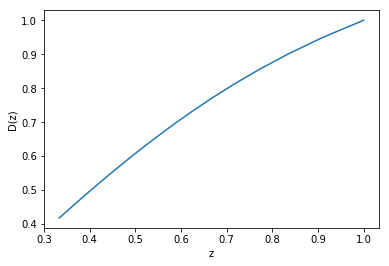

In [322]:
fig, ax = plt.subplots()
ax.plot(a, growth_array)
ax.set_xlabel('z')
ax.set_ylabel('D(z)')

In [18]:
import pickle
dir = '/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/'
f = open(dir+"DIC_DESI_BGS.pkl","rb")
Dic_BGS = pickle.load(f)
f.close()
f = open(dir+"DIC_DESI_LRG.pkl","rb")
Dic_LRG = pickle.load(f)
f.close()
f = open(dir+"DIC_DESI_ELG.pkl","rb")
Dic_ELG = pickle.load(f)
f.close()

In [19]:
print Dic_BGS['nbar_area']/3600
print Dic_LRG['nbar_area']/3600
print Dic_ELG['nbar_area']/3600

0.19444444444444445
0.07833333333333332
0.33805555555555544


In [23]:
# BGS
z_eff_bgs = Dic_BGS['z_eff']
#Area_desi = Dic_BGS['Area']
Vs_bgs = Dic_BGS['Vs_total']
nn_bgs = Dic_BGS['nbar_total']
bD_bgs = Dic_BGS['bD']

params_bgs, _, err_bgs, cov_bfs8_bgs = fractional_error_on_f(z=z_eff_bgs, bD=bD_bgs, s = 3.5, 
                                                         nn=nn_bgs, Vs=Vs_bgs, kmax=0.1)

redshift= 0.1866857142857143
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.6226972953486164
bD(z)= 1.34
b(z=0.19)=1.48
nP14=30.35
nP20=10.17
sigma8(z=0.00)=0.82
sigma8(z=0.19)=0.75
---------------------------------        
 Cov matrix of b and f (Theory) 
[[ 4.81933404e-05 -8.71864889e-05]
 [-8.71864889e-05  3.16592155e-04]]         
---------------------------------
error on bsig8: 0.0052
error on fsig8: 0.0133
fractional error db/b: 0.47%
fractional error df/f: 2.86%
bsig8(z)=1.1035
fsig8(z)=0.4651


In [24]:
# LRG
z_eff_lrg = Dic_LRG['z_eff']
#Area_desi = Dic_BGS['Area']
Vs_lrg = Dic_LRG['Vs_total']
nn_lrg = Dic_LRG['nbar_total']
bD_lrg = Dic_LRG['bD']

params_lrg, _, err_lrg, cov_bfs8_lrg = fractional_error_on_f(z=z_eff_lrg, bD=bD_lrg, s = 3.5, 
                                                         nn=nn_lrg, Vs=Vs_lrg, kmax=0.1)

redshift= 0.7710992907801418
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.8291793839166187
bD(z)= 1.7
b(z=0.77)=2.51
nP14=2.58
nP20=0.99
sigma8(z=0.00)=0.82
sigma8(z=0.77)=0.56
---------------------------------        
 Cov matrix of b and f (Theory) 
[[ 2.90672861e-05 -5.09289432e-05]
 [-5.09289432e-05  1.71449351e-04]]         
---------------------------------
error on bsig8: 0.0030
error on fsig8: 0.0073
fractional error db/b: 0.21%
fractional error df/f: 1.58%
bsig8(z)=1.4000
fsig8(z)=0.4618


In [25]:
# ELG
z_eff_elg = Dic_ELG['z_eff']
#Area_desi = Dic_BGS['Area']
Vs_elg = Dic_ELG['Vs_total']
nn_elg = Dic_ELG['nbar_total']
bD_elg = Dic_ELG['bD']

params_elg, _, err_elg, cov_bfs8_elg = fractional_error_on_f(z=z_eff_elg, bD=bD_elg, s = 3.5, 
                                                         nn=nn_elg, Vs=Vs_elg, kmax=0.1)

redshift= 1.016129827444536
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.8742514791416328
bD(z)= 0.8399999999999999
b(z=1.02)=1.39
nP14=1.82
nP20=0.46
sigma8(z=0.00)=0.82
sigma8(z=1.02)=0.50
---------------------------------        
 Cov matrix of b and f (Theory) 
[[ 5.80170282e-06 -1.03490390e-05]
 [-1.03490390e-05  3.61202038e-05]]         
---------------------------------
error on bsig8: 0.0012
error on fsig8: 0.0030
fractional error db/b: 0.17%
fractional error df/f: 0.69%
bsig8(z)=0.6917
fsig8(z)=0.4360


In [26]:
mean = params_bgs
cov = cov_bfs8_bgs[:2,:2]
chain_desi_bgs = np.random.multivariate_normal(mean, cov, size=50000)

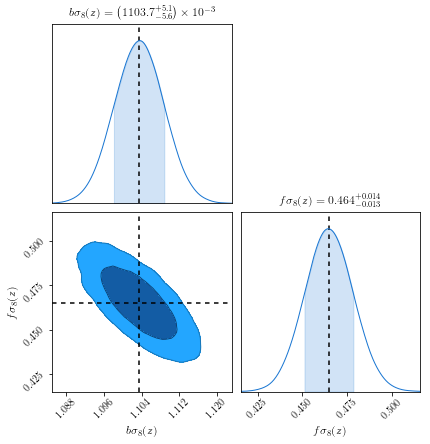

In [27]:
import numpy as np
from chainconsumer import ChainConsumer

parameters=["$b \sigma_8(z)$", "$f \sigma_8(z)$"]

c = ChainConsumer()
c.add_chain(chain_desi_bgs, parameters=parameters, name='DESI BGS')
#c.add_chain(chain_boss, name='desi')

c.configure(plot_hists=True, flip=False, colors = ['blue', 'red', 'orange'], kde=[1])
#c.plotter.plot(filename="example.pdf", figsize=(3,3), truth=mean)
fig = c.plotter.plot(truth=mean)
fig.set_size_inches(3 + fig.get_size_inches())

In [36]:
mean = params_lrg
cov = cov_bfs8_lrg[:2,:2]
chain_desi_lrg = np.random.multivariate_normal(mean, cov, size=50000)

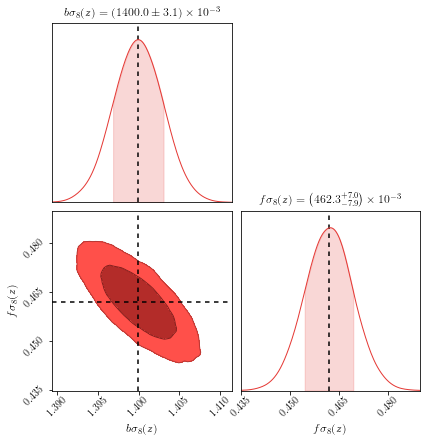

In [37]:
import numpy as np
from chainconsumer import ChainConsumer

parameters=["$b \sigma_8(z)$", "$f \sigma_8(z)$"]

c = ChainConsumer()
c.add_chain(chain_desi_lrg, parameters=parameters, name='DESI LRG')
#c.add_chain(chain_boss, name='desi')

c.configure(plot_hists=True, flip=False, colors = ['red', 'red', 'orange'], kde=[1])
#c.plotter.plot(filename="example.pdf", figsize=(3,3), truth=mean)
fig = c.plotter.plot(truth=mean)
fig.set_size_inches(3 + fig.get_size_inches())

In [ ]:
mean = params_elg
cov = cov_bfs8_elg[:2,:2]
chain_desi_elg = np.random.multivariate_normal(mean, cov, size=50000)

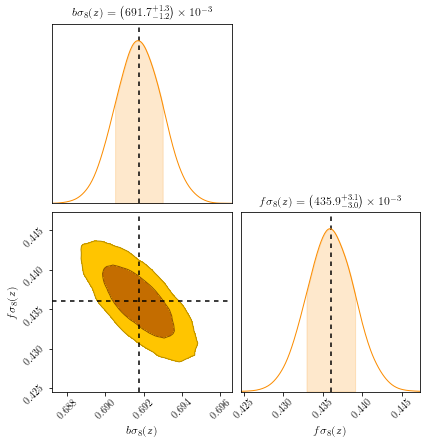

In [31]:
import numpy as np
from chainconsumer import ChainConsumer

parameters=["$b \sigma_8(z)$", "$f \sigma_8(z)$"]

c = ChainConsumer()
c.add_chain(chain_desi_elg, parameters=parameters, name='DESI ELG')
#c.add_chain(chain_boss, name='desi')

c.configure(plot_hists=True, flip=False, colors = ['orange', 'red', 'orange'], kde=[1])
#c.plotter.plot(filename="example.pdf", figsize=(3,3), truth=mean)
fig = c.plotter.plot(truth=mean)
fig.set_size_inches(3 + fig.get_size_inches())

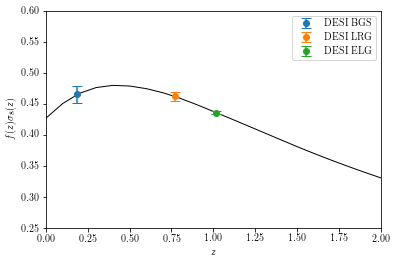

In [32]:
fig, ax = plt.subplots()
ax.plot(zbins, fz_theory*sigma8_array, 'k-', lw=1)
ax.errorbar(z_eff_bgs, params_bgs[1], yerr=err_bgs[1], fmt='o', capsize=5, label='DESI BGS')
ax.errorbar(z_eff_lrg, params_lrg[1], yerr=err_lrg[1], fmt='o', capsize=5, label='DESI LRG')
ax.errorbar(z_eff_elg, params_elg[1], yerr=err_elg[1], fmt='o', capsize=5, label='DESI ELG')

ax.legend()
ax.set_xlim(0,2)
ax.set_ylim(0.25, 0.6)
ax.set_xlabel('$z$')
ax.set_ylabel('$f(z)\sigma_8 (z)$')

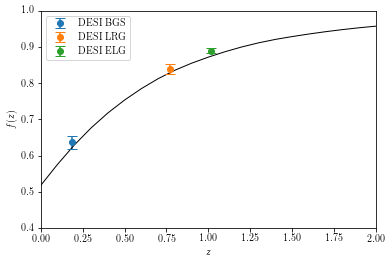

In [33]:
sig8_bgs = 0.73
sig8_lrg = 0.55
sig8_elg = 0.49

fig, ax = plt.subplots()
ax.plot(zbins, fz_theory, 'k-', lw=1)
ax.errorbar(z_eff_bgs, params_bgs[1]/sig8_bgs, yerr=err_bgs[1]/sig8_bgs, fmt='o', capsize=5, label='DESI BGS')
ax.errorbar(z_eff_lrg, params_lrg[1]/sig8_lrg, yerr=err_lrg[1]/sig8_lrg, fmt='o', capsize=5, label='DESI LRG')
ax.errorbar(z_eff_elg, params_elg[1]/sig8_elg, yerr=err_elg[1]/sig8_elg, fmt='o', capsize=5, label='DESI ELG')

ax.legend()
ax.set_xlim(0,2)
ax.set_ylim(0.4, 1.0)
ax.set_xlabel('$z$')
ax.set_ylabel('$f(z)$')

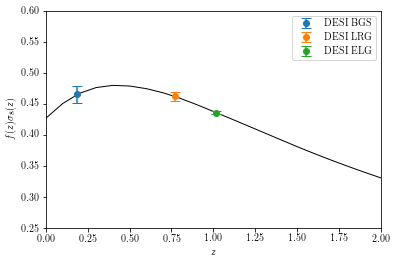

In [34]:
fig, ax = plt.subplots()
ax.plot(zbins, fz_theory*sigma8_array, 'k-', lw=1)
ax.errorbar(z_eff_bgs, params_bgs[1], yerr=err_bgs[1], fmt='o', capsize=5, label='DESI BGS')
ax.errorbar(z_eff_lrg, params_lrg[1], yerr=err_lrg[1], fmt='o', capsize=5, label='DESI LRG')
ax.errorbar(z_eff_elg, params_elg[1], yerr=err_elg[1], fmt='o', capsize=5, label='DESI ELG')

ax.legend()
ax.set_xlim(0,2)
ax.set_ylim(0.25, 0.6)
ax.set_xlabel('$z$')
ax.set_ylabel('$f(z)\sigma_8 (z)$')

## Fine Bins

In [38]:
params_bgs, sum_fracerr_bgs, sum_err_bgs, sum_cov_bfs8_bgs = sum_finebin_errors(Dic_BGS)

redshift= 0.1866857142857143
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.6226972953486164
bD(z)= 1.34
b(z=0.19)=1.48
nP14=30.35
nP20=10.17
sigma8(z=0.00)=0.82
sigma8(z=0.19)=0.75
---------------------------------        
 Cov matrix of b and f (Theory) 
[[ 4.81933404e-05 -8.71864889e-05]
 [-8.71864889e-05  3.16592155e-04]]         
---------------------------------
error on bsig8: 0.0052
error on fsig8: 0.0133
fractional error db/b: 0.47%
fractional error df/f: 2.86%
bsig8(z)=1.1035
fsig8(z)=0.4651
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.05)=0.80
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}


In [39]:
params_elg, sum_fracerr_elg, sum_err_elg, sum_cov_bfs8_elg = sum_finebin_errors(Dic_ELG)

redshift= 1.016129827444536
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.8742514791416328
bD(z)= 0.8399999999999999
b(z=1.02)=1.39
nP14=1.82
nP20=0.46
sigma8(z=0.00)=0.82
sigma8(z=1.02)=0.50
---------------------------------        
 Cov matrix of b and f (Theory) 
[[ 5.80170282e-06 -1.03490390e-05]
 [-1.03490390e-05  3.61202038e-05]]         
---------------------------------
error on bsig8: 0.0012
error on fsig8: 0.0030
fractional error db/b: 0.17%
fractional error df/f: 0.69%
bsig8(z)=0.6917
fsig8(z)=0.4360
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.65)=0.59
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0

In [49]:
params_lrg, sum_fracerr_lrg, sum_err_lrg, sum_cov_bfs8_lrg = sum_finebin_errors(Dic_LRG)

redshift= 0.7710992907801418
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.8291793839166187
bD(z)= 1.7
b(z=0.77)=2.51
nP14=2.58
nP20=0.99
sigma8(z=0.00)=0.82
sigma8(z=0.77)=0.56
---------------------------------        
 Cov matrix of b and f (Theory) 
[[ 2.90672861e-05 -5.09289432e-05]
 [-5.09289432e-05  1.71449351e-04]]         
---------------------------------
error on bsig8: 0.0030
error on fsig8: 0.0073
fractional error db/b: 0.21%
fractional error df/f: 1.58%
bsig8(z)=1.4000
fsig8(z)=0.4618
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.65)=0.59
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sig

In [50]:
# LRG

z_lrg = Dic_LRG['z']
Vs_lrg = Dic_LRG['Vs']
nn_lrg = Dic_LRG['nbar']
bD_lrg = Dic_LRG['bD']


params_lrg_array = np.zeros((2,z_lrg.size)) #np.zeros(zarray.size)
err_lrg_array = np.zeros((2,z_lrg.size)) #np.zeros(zarray.size)
cov_bfs8_lrg_array = np.zeros((2,2,z_lrg.size))
for i in range(z_lrg.size):
    if nn_lrg[i] == 0: pass
    else: params_lrg_array[:,i], _, err_lrg_array[:,i], cov_bfs8_lrg_array[:,:,i] = fractional_error_on_f(z=z_lrg[i], bD=bD_lrg, s = 3.5, 
                                                         nn=nn_lrg[i], Vs=Vs_lrg[i], kmax=0.1, verbose=False)



compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.65)=0.59
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.75)=0.56
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.85)=0.54
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.95)=0.51
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82


In [51]:
# BGS

z_bgs = Dic_BGS['z']
Vs_bgs = Dic_BGS['Vs']
nn_bgs = Dic_BGS['nbar']
bD_bgs = Dic_BGS['bD']

params_bgs_array = np.zeros((2,z_bgs.size)) #np.zeros(zarray.size)
err_bgs_array = np.zeros((2,z_bgs.size)) #np.zeros(zarray.size)
cov_bfs8_bgs_array = np.zeros((2,2,z_bgs.size))
for i in range(z_bgs.size):
    params_bgs_array[:,i], _, err_bgs_array[:,i], cov_bfs8_bgs_array[:,:,i] = fractional_error_on_f(z=z_bgs[i], bD=bD_bgs, s = 3.5, 
                                                         nn=nn_bgs[i], Vs=Vs_bgs[i], kmax=0.1, verbose=False)



compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.05)=0.80
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.15)=0.76
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.25)=0.72
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.35)=0.69
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82


In [52]:
# ELG

z_elg = Dic_ELG['z']
Vs_elg = Dic_ELG['Vs']
nn_elg = Dic_ELG['nbar']
bD_elg = Dic_ELG['bD']

params_elg_array = np.zeros((2,z_elg.size)) #np.zeros(zarray.size)
err_elg_array = np.zeros((2,z_elg.size)) #np.zeros(zarray.size)
cov_bfs8_elg_array = np.zeros((2,2,z_elg.size))
for i in range(z_elg.size):
    params_elg_array[:,i], _, err_elg_array[:,i], cov_bfs8_elg_array[:,:,i] = fractional_error_on_f(z=z_elg[i], bD=bD_elg, s = 3.5, 
                                                         nn=nn_elg[i], Vs=Vs_elg[i], kmax=0.1, verbose=False)


compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.65)=0.59
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.75)=0.56
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.85)=0.54
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82
sigma8(z=0.95)=0.51
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
sigma8(z=0.00)=0.82


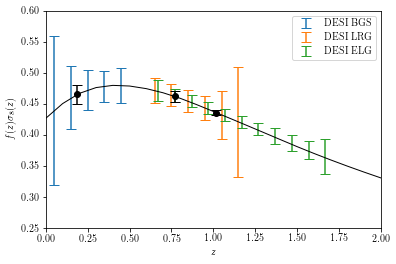

In [54]:
fig, ax = plt.subplots()
ax.plot(zbins, fz_theory * sigma8_array, 'k-', lw=1)

#for i in range(zarray.size): 
ax.errorbar(z_bgs, params_bgs_array[1,:], yerr=err_bgs_array[1,:], fmt='none', color=None, capsize=5, label='DESI BGS')
ax.errorbar(z_lrg, params_lrg_array[1,:], yerr=err_lrg_array[1,:], fmt='none', color=None, capsize=5, label='DESI LRG' )
ax.errorbar(z_elg+0.02, params_elg_array[1,:], yerr=err_elg_array[1,:], fmt='none', color=None, capsize=5, label='DESI ELG')

ax.errorbar(z_eff_bgs, params_bgs[1], yerr=sum_err_bgs[1], fmt='o', color='k', capsize=5)
ax.errorbar(z_eff_lrg, params_lrg[1], yerr=sum_err_lrg[1], fmt='o', color='k', capsize=5)
ax.errorbar(z_eff_elg, params_elg[1], yerr=sum_err_elg[1], fmt='o', color='k', capsize=5)


ax.legend()
ax.set_xlim(0,2)
ax.set_ylim(0.25, 0.6)
ax.set_xlabel('$z$')
ax.set_ylabel('$f(z)\sigma_8 (z)$')
#ax.set_ylabel('$f(z)$')

# Multi tracers

In [60]:
def call_galaxy_sample(z=None, bD=None, f=None, Vs=None, nn=None, kmax=0.1, verbose=True):
    
    cosmo = class_covariance(z=z, 
                         KMIN=0.001, KMAX = 5, n=5000, 
                         b = bD, f = f, s=3.5, nn=nn, Vs=Vs,
                         rscale = 'lin', kscale='lin', 
                         smooth_filter=False)
    cosmo.MatterPower(z=z)

    if f is None: f = cosmo.compute_fz(z=z)
    cosmo.f = f
    if verbose: print 'f(z)=',cosmo.f

    growth = cosmo.cosmology.growthFactor(z)
    cosmo.b = bD/growth

    if verbose:
        print 'bD(z)=',cosmo.b*growth
        print 'b(z={:0.2f})={:0.2f}'.format(cosmo.z, cosmo.b)

    Pkmu14 = cosmo.Pkmu(0.14, 1.6)
    #Pkmu20 = cosmo.Pkmu(0.2, 0)
    if verbose:
        print 'nP14={:0.2f}'.format(cosmo.nn * Pkmu14)
        #print 'nP20={:0.2f}'.format(cosmo.nn * Pkmu20)
        
    cosmo.sigma8 = cosmo.compute_sigma8(z=cosmo.z)
    
    return cosmo

In [61]:
def Pkmu_multi_tracer_FisherComputation(cosmo_a, cosmo_b, kmin=None, kmax=None, Nq=2):
    
    kbin = cosmo_a.kcenter
    matrix1, matrix2 = np.mgrid[0:cosmo_a.mulist.size,0:kbin.size]
    mumatrix = cosmo_a.mulist[matrix1]
    kmatrix = kbin[matrix2]
    #P = self.Pband_interp(kbin, self.mulist)
    
    
    
    b_a = cosmo_a.b
    #f_a = cosmo_a.f
    nn_a = cosmo_a.nn
    P_a = nn_a* cosmo_a.Pband_interp(kbin, cosmo_a.mulist)
    
    b_b = cosmo_b.b
    #f_b = cosmo_b.f
    nn_b = cosmo_b.nn
    P_b = nn_b* cosmo_b.Pband_interp(kbin, cosmo_b.mulist)
    
    # shared parameters
    f = cosmo_a.f
    PP = [P_a, P_b]
    P = P_a + P_b
    Vs = cosmo_a.Vs

    dlnP_db_a = 2. /(b_a + f * mumatrix**2) 
    dlnP_df_a = 2. * mumatrix**2 /(b_a+f*mumatrix**2)
    dlnP_db_b = 2. /(b_b + f * mumatrix**2) 
    dlnP_df_b = 2. * mumatrix**2 /(b_b+f*mumatrix**2)
    dlnP_dq = [[dlnP_db_a, dlnP_df_a], [dlnP_db_b, dlnP_df_b]]
    
    #dlnP_dq_b = [dlnP_db_b, dlnP_df_b]
    #dlnP_ds =  -1* kmatrix**2 * mumatrix**2 
    #dlnP_dq = [dlnP_db_a, dlnP_db_b, ]
    
    
    Veff = Vs # * (self.nn * P/( 1 + self.nn * P))**2
    
    def delta(i,j):
        if i==j: return 1.0
        else: return 0.0
        
    Nq = 4
    matrix_muint = np.zeros((Nq, Nq, kbin.size))
    prefactor = 2*np.pi*kmatrix**2/(2*np.pi)**3
    
    for i in range(2):
        for j in range(2):
            F_ij = 1./4 * ( delta(i,j)*PP[i]*P/(1.+P) + (PP[i]*PP[j]*(1.-P))/(1.+P)**2 )
            for k in range(2):
                for l in range(2):
                    matrix_muint[2*i+k,2*j+l,:] = \
                    1.0 * romberg( prefactor*dlnP_dq[i][k] * F_ij * dlnP_dq[j][l] * Veff, \
                    dx=cosmo_a.dmu, axis=0)
    
    # masking 
    if kmin == None : 
        idx_kmin = 0
        idx_kmax = cosmo_a.kbin.size
    else : 
        idx_kmin = get_closest_index_in_data( kmin, cosmo_a.kbin )   
        idx_kmax = get_closest_index_in_data( kmax, cosmo_a.kbin )

    mask = np.zeros(kbin.size, dtype=bool)
    mask[idx_kmin:idx_kmax+1] = 1

    Fisher = np.zeros((Nq,Nq))
    for i in range(Nq):
        for j in range(Nq):
            Fisher[i,j] = simpson( matrix_muint[i,j,:][mask], kbin[mask] )
    
    sigma8 = cosmo_a.sigma8    
    #params = np.array([b_a, b_b, f_a, f_b])
    params = np.array([b_a, f, b_b, f])
    params_sig8 = params * sigma8
    
    return params_sig8, Fisher/sigma8**2
    

In [62]:
def _Pkmu_multi_tracer_FisherComputation(cosmo_a, cosmo_b, kmin=None, kmax=None, Nq=2):
    
    kbin = cosmo_a.kcenter
    matrix1, matrix2 = np.mgrid[0:cosmo_a.mulist.size,0:kbin.size]
    mumatrix = cosmo_a.mulist[matrix1]
    kmatrix = kbin[matrix2]
    #P = self.Pband_interp(kbin, self.mulist)
    
    sigma8 = cosmo_a.sigma8
    
    b_a = cosmo_a.b
    #f_a = cosmo_a.f
    nn_a = cosmo_a.nn
    P_a = nn_a* cosmo_a.Pband_interp(kbin, cosmo_a.mulist)
    
    b_b = cosmo_b.b
    #f_b = cosmo_b.f
    nn_b = cosmo_b.nn
    P_b = nn_b* cosmo_b.Pband_interp(kbin, cosmo_b.mulist)
    
    # shared parameters
    f = cosmo_a.f
    PP = [P_a, P_b]
    P = P_a + P_b
    Vs = cosmo_a.Vs

    dlnP_db_a = 2. /(b_a + f * mumatrix**2) 
    dlnP_df_a = 2. * mumatrix**2 /(b_a+2*f*mumatrix**2)
    dlnP_db_b = 2. /(b_b + f * mumatrix**2) 
    dlnP_df_b = 2. * mumatrix**2 /(b_b+2*f*mumatrix**2)
    dlnP_dq = [[dlnP_db_a, dlnP_df_a], [dlnP_db_b, dlnP_df_b]]    
    
    Veff = Vs # * (self.nn * P/( 1 + self.nn * P))**2
    
    def delta(i,j):
        if i==j: return 1.0
        else: return 0.0
        
    Nq = 4
    matrix_muint = np.zeros((Nq, Nq, kbin.size))
    prefactor = 2*np.pi*kmatrix**2/(2*np.pi)**3
    
    for i in range(2):
        for j in range(2):
            F_ij = 1./4 * ( delta(i,j)*PP[i]*P/(1.+P) + (PP[i]*PP[j]*(1.-P))/(1.+P)**2 )
            for k in range(2):
                for l in range(2):
                    #print 2*i+k,2*j+l
                    matrix_muint[2*i+k,2*j+l,:] =  \
                    romberg(prefactor* dlnP_dq[i][k] * F_ij * dlnP_dq[j][l] * Veff,\
                                  dx=cosmo_a.dmu, axis=0)
    
    # masking 
    if kmin == None : 
        idx_kmin = 0
        idx_kmax = cosmo_a.kbin.size
    else : 
        idx_kmin = get_closest_index_in_data( kmin, cosmo_a.kbin )   
        idx_kmax = get_closest_index_in_data( kmax, cosmo_a.kbin )

    mask = np.zeros(kbin.size, dtype=bool)
    mask[idx_kmin:idx_kmax+1] = 1

    Fisher = np.zeros((Nq,Nq))
    for i in range(Nq):
        for j in range(Nq):
            Fisher[i,j] = simpson( matrix_muint[i,j,:][mask], kbin[mask] )

    

    #Cov_bf = np.linalg.inv(Fisher)
    
    # projection to three params
    
    Projection = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,1]])
    Fisher_projected = np.dot(np.dot(Projection, Fisher ), Projection.T)
    Cov_bf = np.linalg.inv(Fisher_projected)
    #return Fisher_projected
    #print Fisher_projected
    
    
    
    #Cov_bfs8 = np.linalg.inv(Fisher)*sigma8**2
    #Fisher_bfs8 = np.linalg.inv(Cov_bfs8)
    
    
    #params = np.array([b_a, f_a, b_b, f_b])
    params = np.array([b_a, b_b, f])
    params_sig8 = params * sigma8
    Cov_bf_sig8 = Cov_bf * sigma8**2
    err_bf_sig8 = np.sqrt(Cov_bf_sig8.diagonal())
    return params_sig8, err_bf_sig8, Cov_bf_sig8
    # integration
    
    #return params_sig8, Fisher_bfs8 #/sigma8**2
    

In [63]:
# LRG
#z_a = Dic_LRG['z_eff']
z_a = Dic_LRG['z']
Vs_a = Dic_LRG['Vs']
nn_a = Dic_LRG['nbar']
bD_a = Dic_LRG['bD']

# ELG
z_b = Dic_ELG['z']
Vs_b = Dic_ELG['Vs']
nn_b = Dic_ELG['nbar']
bD_b = Dic_ELG['bD']

In [68]:
params_cross_bfs8 = np.zeros((3, z_a.size))
err_cross_bfs8 = np.zeros((3, z_a.size))
Cov_cross_bfs8 = np.zeros((3,3,z_a.size))
Fisher_cross_bfs8 = np.zeros((3,3,z_a.size))

for i in range(z_a.size):
    galaxy_lrg = call_galaxy_sample(z=z_a[i], bD=bD_a, f=None, Vs=Vs_a[i], nn=nn_a[i])
    galaxy_elg = call_galaxy_sample(z=z_a[i], bD=bD_a, f=None, Vs=Vs_a[i], nn=nn_a[i])
    
    params_cross_bfs8[:,i], err_cross_bfs8[:,i], Cov_cross_bfs8[:,:,i] = \
    _Pkmu_multi_tracer_FisherComputation(galaxy_lrg, galaxy_elg, kmin=0.0001, kmax=0.1, Nq=2)
    

compute matter power spectrum using Colossus
Set cosmology to  planck18
f(z)= 0.8026561033652493
bD(z)= 1.7
b(z=0.65)=2.38
nP14=6.51
nP20=2.47
sigma8(z=0.65)=0.58
compute matter power spectrum using Colossus
Set cosmology to  planck18
f(z)= 0.8026561033652493
bD(z)= 1.7
b(z=0.65)=2.38
nP14=6.51
nP20=2.47
sigma8(z=0.65)=0.58
compute matter power spectrum using Colossus
Set cosmology to  planck18
f(z)= 0.8277299607606556
bD(z)= 1.7
b(z=0.75)=2.50
nP14=6.39
nP20=2.44
sigma8(z=0.75)=0.55
compute matter power spectrum using Colossus
Set cosmology to  planck18
f(z)= 0.8277299607606556
bD(z)= 1.7
b(z=0.75)=2.50
nP14=6.39
nP20=2.44
sigma8(z=0.75)=0.55
compute matter power spectrum using Colossus
Set cosmology to  planck18
f(z)= 0.8488271723733636
bD(z)= 1.7000000000000002
b(z=0.85)=2.61
nP14=3.66
nP20=1.42
sigma8(z=0.85)=0.53
compute matter power spectrum using Colossus
Set cosmology to  planck18
f(z)= 0.8488271723733636
bD(z)= 1.7000000000000002
b(z=0.85)=2.61
nP14=3.66
nP20=1.42
sigma8(z=0.8

LinAlgError: Singular matrix

In [64]:
Nq = 4
params_cross_bfs8 = np.zeros((Nq, z_a.size))
#err_cross_bfs8 = np.zeros((Nq, z_a.size))
Fisher_cross_bfs8 = np.zeros((Nq,Nq,z_a.size))
Cov_cross_bfs8_array = np.zeros((3,3,z_a.size))
err_cross_bfs8_array = np.zeros((3, z_a.size))

for i in range(z_b.size): #z_a.size):
    galaxy_lrg = call_galaxy_sample(z=z_a[i], bD=bD_a, f=None, Vs=Vs_a[i], nn=nn_a[i])
    galaxy_elg = call_galaxy_sample(z=z_b[i], bD=bD_b, f=None, Vs=Vs_b[i], nn=nn_b[i])
    
    params_cross_bfs8[:,i], Fisher_cross_bfs8[:,:,i] = \
    Pkmu_multi_tracer_FisherComputation(galaxy_lrg, galaxy_elg, kmin=0.0001, kmax=0.1, Nq=2)
    
    Projection = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,1]])
    Fisher = np.dot(np.dot(Projection, Fisher_cross_bfs8[:,:,i] ), Projection.T)
    
    if galaxy_lrg.nn == 0: mask = np.outer(np.array([0,1,1], dtype=bool),np.array([0,1,1], dtype=bool))
    elif galaxy_elg.nn == 0: mask = np.outer(np.array([1,0,1], dtype=bool),np.array([1,0,1], dtype=bool))
    else: mask = np.ones((3,3), dtype=bool)
        
    #masked_Fisher = Fisher[mask]
    Np = int(np.sqrt(np.sum(mask)))
    Covcut = np.linalg.inv(Fisher[mask].reshape(Np,Np))
    Cov = np.full((3,3), np.nan)
    Cov[mask] = Covcut.ravel()
    
    #Cov = np.linalg.inv(Fisher)
    Cov_cross_bfs8_array[:,:,i] = Cov    
    err_cross_bfs8_array[:,i] = np.sqrt( Cov.diagonal())

compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.7989430790268816
bD(z)= 1.7
b(z=0.65)=2.37
nP14=6.72
sigma8(z=0.65)=0.59
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.7989430790268816
bD(z)= 0.84
b(z=0.65)=1.17
nP14=0.96
sigma8(z=0.65)=0.59
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.8243328441349451
bD(z)= 1.7
b(z=0.75)=2.49
nP14=6.59
sigma8(z=0.75)=0.56
compute matter power spectrum using Colossus
Set cosmology to  {'flat': True, 'H0': 67.8596, 'Om0': 0.3057076, 'sigma8': 0.8235, 'ns': 0.968376, 'Ob0': 0.04845864}
f(z)= 0.8243328441349451
bD(z)= 0.84
b(z=0.75)=1.23
nP14=5.83
sigma8(z=0.75)=0.56
compute matter pow

In [66]:
sum_Fisher_cross_bfs8 = np.sum(Fisher_cross_bfs8, axis=-1)
sum_Cov_cross_bfs8 = np.linalg.inv(sum_Fisher_cross_bfs8)
sum_err_cross_bfs8 = np.sqrt(sum_Cov_cross_bfs8.diagonal() )

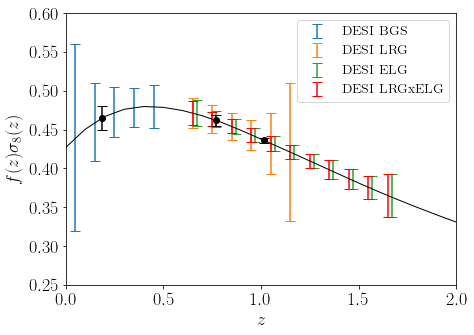

In [87]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(zbins, fz_theory * sigma8_array, 'k-', lw=1)

#for i in range(zarray.size): 
ax.errorbar(z_bgs, params_bgs_array[1,:], yerr=err_bgs_array[1,:], fmt='none', color=None, capsize=5, label='DESI BGS')
ax.errorbar(z_lrg, params_lrg_array[1,:], yerr=err_lrg_array[1,:], fmt='none', color=None, capsize=5, label='DESI LRG' )
ax.errorbar(z_elg+0.02, params_elg_array[1,:], yerr=err_elg_array[1,:], fmt='none', color=None, capsize=5, label='DESI ELG')

ax.errorbar(z_eff_bgs, params_bgs[1], yerr=sum_err_bgs[1], fmt='o', color='k', capsize=5)
#ax.errorbar(z_eff_lrg, params_lrg[1], yerr=sum_err_lrg[1], fmt='o', color='k', capsize=5)
#ax.errorbar(z_eff_elg, params_elg[1], yerr=sum_err_elg[1], fmt='o', color='k', capsize=5)


#ax.errorbar(z_a, params_cross_bfs8[1,:], yerr=err_cross_bfs8[1,:], fmt='none', color='red', capsize=5, label='DESI LRGxELG' )
ax.errorbar(z_a, params_cross_bfs8[3,:], yerr=err_cross_bfs8_array[2,:], fmt='none', color='red', capsize=5, label='DESI LRGxELG' )

ax.errorbar(z_eff_lrg, params_lrg[1], yerr=sum_err_cross_bfs8[1], fmt='o', color='k', capsize=5)
ax.errorbar(z_eff_elg, params_elg[1], yerr=sum_err_cross_bfs8[3], fmt='o', color='k', capsize=5)


ax.legend(fontsize=14, loc=1)
ax.tick_params(labelsize=18)
ax.set_xlim(0,2)
ax.set_ylim(0.25, 0.6)
ax.set_xlabel('$z$', size=18)
ax.set_ylabel('$f(z)\sigma_8 (z)$', size=18)
#ax.set_ylabel('$f(z)$')

In [90]:
sum_err_cross_bfs8

array([0.00303777, 0.00703995, 0.00132418, 0.00331526])

In [91]:
# Error of each sample
print 'name             :   bgs |   lrg |   elg'
print 'redshift         : {:0.2f}  | {:0.2f}  | {:0.2f} '.format(z_eff_bgs, z_eff_lrg, z_eff_elg)
print 'Auto FracError f : {:0.2f}% | {:0.2f}% | {:0.2f}%'.format(sum_err_bgs[1]*100/params_bgs[1], sum_err_lrg[1]*100/params_lrg[1], sum_err_elg[1]*100/params_elg[1])
print 'Full FracError f : {:0.2f}% | {:0.2f}% | {:0.2f}%'.format(sum_err_bgs[1]*100/params_bgs[1], sum_err_cross_bfs8[1]*100/params_lrg[1], sum_err_cross_bfs8[3]*100/params_elg[1])
print ''
print 'Auto FracError b : {:0.2f}% | {:0.2f}% | {:0.2f}%'.format(sum_err_bgs[0]*100/params_bgs[0], sum_err_lrg[0]*100/params_lrg[0], sum_err_elg[0]*100/params_elg[0])
print 'Full FracError b : {:0.2f}% | {:0.2f}% | {:0.2f}%'.format(sum_err_bgs[0]*100/params_bgs[0], sum_err_cross_bfs8[0]*100/params_lrg[0], sum_err_cross_bfs8[2]*100/params_elg[0])
print ''
print 'bsigma8   : {:0.5f} | {:0.5f} | {:0.5f}'.format(params_bgs[0], params_lrg[0], params_elg[0])
print 'fsigma8   : {:0.5f} | {:0.5f} | {:0.5f}'.format(params_bgs[1], params_lrg[1], params_elg[1])




name             :   bgs |   lrg |   elg
redshift         : 0.19  | 0.77  | 1.02 
Auto FracError f : 3.27% | 1.93% | 0.77%
Full FracError f : 3.27% | 1.52% | 0.76%

Auto FracError b : 0.55% | 0.26% | 0.20%
Full FracError b : 0.55% | 0.22% | 0.19%

bsigma8   : 1.10350 | 1.39996 | 0.69175
fsigma8   : 0.46508 | 0.46183 | 0.43600


In [69]:
FullCov = np.zeros((6,6))
FullCov[:2,:2] =sum_cov_bfs8_bgs
FullCov[2:,2:] = sum_Cov_cross_bfs8 

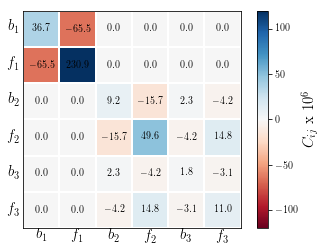

In [86]:
fig, ax = plt.subplots()
im = ax.imshow(FullCov*10**6, cmap='RdBu', vmax=120, vmin=-120)
cbar = fig.colorbar(im, ax=ax )
cbar.set_label('$C_{ij}$ x $10^6$', size=15)

ax.tick_params(which='both', size=0)
ax.set_xticklabels([ '$b_1$','$f_1$', '$b_2$', '$f_2$', '$b_3$' , '$f_3$' ], size=15)
ax.set_yticklabels([ '$b_1$','$f_1$', '$b_2$', '$f_2$', '$b_3$' , '$f_3$' ], size=15)

# Minor ticks
ax.set_xticks(np.arange(0,6,1))
ax.set_yticks(np.arange(0,6,1))

ax.set_xticks(np.arange(-.5, 6, 1), minor=True)
ax.set_yticks(np.arange(-.5, 6, 1), minor=True)
#ax.set_xlim(-0.5,5.5)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)


for (j,i),value in np.ndenumerate(FullCov*10**6):
    label = '${:0.1f}$'.format(value)
    ax.text(i,j,label,ha='center',va='center')


In [71]:
params_datav = np.array( [params_bgs, params_lrg, params_elg]).reshape(6,1)

In [72]:
comments = 'z1={:0.2f}\nz2={:0.2f}\nz3={:0.2f}'.format(z_eff_bgs, z_eff_lrg, z_eff_elg)
comments += '\nb1, f1, b2, f2, b3, f3'

In [73]:
savedir = '/n/des/lee.5922/programs/cosmolike/LSST-forecasts/data/'
filename_cov = savedir+'cov_DESI_BGS_LRGxELG.txt'
filename_dv = savedir+'simulated_datav_DESI_BGS_LRGxELG.txt'

np.savetxt(filename_dv, params_datav, delimiter=' ', header=comments)
np.savetxt(filename_cov, FullCov, delimiter=' ', header=comments)

### Number density per arcmin^2

In [287]:
print Dic_BGS['nbar_area']/3600
print Dic_LRG['nbar_area']/3600
print Dic_ELG['nbar_area']/3600

0.19444444444444445
0.07833333333333332
0.33805555555555544
